In [2]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=74aee2a15ead6c1895d3e87c403ba436a0719c69c1ee71c1b29b45031ad7294d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [3]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm

from smallnorb_datareader import *

/kaggle/usr/lib/smallnorb_datareader/smallnorb_datareader.py:142: SyntaxWarning: "is" with a literal. Did you mean "=="?
  target = self.labels[index % 24300] if self.mode is "all" else self.labels[index]
/kaggle/usr/lib/smallnorb_datareader/smallnorb_datareader.py:146: SyntaxWarning: "is" with a literal. Did you mean "=="?
  info = self.infos[index % 24300] if self.mode is "all" else self.infos[index]
/kaggle/usr/lib/smallnorb_datareader/smallnorb_datareader.py:483: SyntaxWarning: "is" with a literal. Did you mean "=="?
  self.data = self.data[indices + [i + 24300 for i in indices]] if self.mode is 'all' else self.data[indices]
/kaggle/usr/lib/smallnorb_datareader/smallnorb_datareader.py:497: SyntaxWarning: "is" with a literal. Did you mean "=="?
  target = self.labels[index % len(self.infos)] if self.mode is "all" else self.labels[index]
/kaggle/usr/lib/smallnorb_datareader/smallnorb_datareader.py:501: SyntaxWarning: "is" with a literal. Did you mean "=="?
  info = self.infos[index %

In [2]:
import pickle

In [4]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [5]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from albumentations import Compose, Resize, Normalize, Rotate, ShiftScaleRotate, RandomBrightnessContrast, GaussianBlur, GaussNoise
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
random.seed(42)

## loading data

In [8]:
BATCH_SIZE = 64

In [9]:
train_dataset=smallNORBViewPoint(root='../input/smallnorb-processed',train=True,download=True)
test_dataset=smallNORBViewPoint(root='../input/smallnorb-processed',train=False,download=True)

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
class NORBDataset(Dataset):
    def __init__(self, norb_dataset, transform=None):
        self.norb_dataset = norb_dataset
        self.transform = transform

    def __len__(self):
        return len(self.norb_dataset)

    def __getitem__(self, idx):
        image, label = self.norb_dataset[idx]
        image = np.array(image)  # Convert PIL image to numpy array
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

In [24]:
def get_train_augmentation():
    train_transform = [
#         A.HorizontalFlip(p=0.5),
#         A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=1, shadow_dimension=5, always_apply=False, p=0.5),
#         Rotate(limit=45, p=0.5),
#         ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=0, p=0.5),
#         RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
#         GaussianBlur(blur_limit=(1, 5), p=0.5),
        Resize(260, 260),  # Resize images to 227x227
        Normalize(mean=[0.0989], std=[0.7513]),  # Normalize images
        ToTensorV2(),
    ]
    return Compose(train_transform)

In [53]:
def get_val_augmentation():
    train_transform = [
#         transforms.Grayscale(num_output_channels=3),
#         Rotate(limit=0, p=0.5),
#         ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.4),
        RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.5),
#         GaussianBlur(blur_limit=5, p=0.5),
        Resize(260, 260),  # Resize images to 227x227
        Normalize(mean=[0.0989], std=[0.7513]),
        ToTensorV2(),
    ]
    return Compose(train_transform)

In [26]:
# train_set = NORBDataset(train_dataset, transform=get_train_augmentation())
train_set = NORBDataset(train_dataset, transform=get_train_augmentation())
trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

In [27]:
# trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
                                      
# train_set = MNISTDataset(trainset, transform=get_val_augmentation())

# trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
#                                           shuffle=True, num_workers=2)

# classes = tuple(str(i) for i in range(10))

In [54]:
test_set = NORBDataset(test_dataset, transform=get_val_augmentation())

# Create a DataLoader
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [29]:
# testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

# #test images (with augmentation)
# custom_dataset = MNISTDataset(testset, transform=get_train_augmentation())

# # Create a DataLoader
# testloader = DataLoader(custom_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

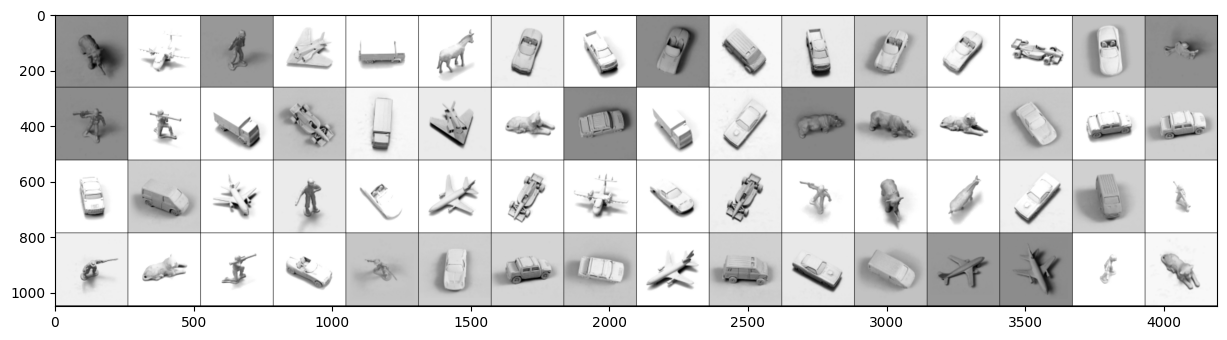

In [30]:
#train images (no augmentation)
images, labels = next(iter(trainloader))
grid_img = torchvision.utils.make_grid(images, nrow=16)
plt.figure(figsize=(15,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

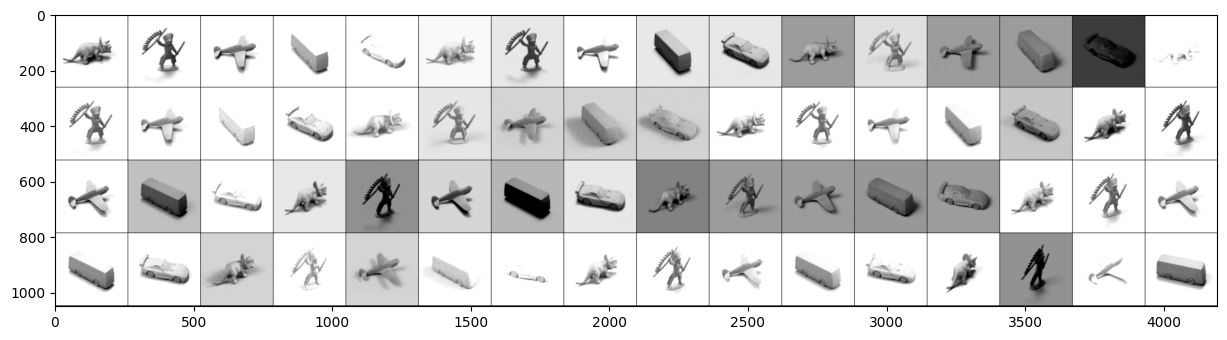

In [50]:
# Visualize valid images
images, labels = next(iter(testloader))
grid_img = torchvision.utils.make_grid(images, nrow=16)
plt.figure(figsize=(15,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [32]:
NUM_CLASSES = 5

## model

In [33]:
model = EfficientNet.from_name('efficientnet-b2', num_classes=NUM_CLASSES, in_channels=1).to(device)

In [34]:
model.load_state_dict(torch.load('/kaggle/input/efb2-weights/model_weights_orig.pth'))

<All keys matched successfully>

In [35]:
LEARNING_RATE = 0.00015
EPOCHS = 10

In [36]:
# model = AlexNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [49]:
# model.load_state_dict(torch.load('/kaggle/input/alexnet-weights/model_weights_no_augs.pth'))

## train and test functions

In [50]:
train_losses=[]
train_accu=[]

def train(epoch):
    print('\nEpoch : %d'%epoch)

    model.train()

    running_loss=0
    correct=0
    total=0
    
    for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = model(X_batch.to(device))
        loss = criterion(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()
                              
        running_loss += loss.item()
        
        labels = y_batch.to(device)
        _, predicted = y_pred.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

#         if i % 40 == 39:
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 40))
#             train_losses.append(running_loss / 40)
#             running_loss = 0.0
#             accu = 100. * correct / total
#             train_accu.append(accu)
             
                              
    train_loss = running_loss / len(trainloader)
    accu = 100. * correct / total

    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [37]:
eval_losses=[]
eval_accu=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0

    with torch.no_grad():
        for i, batch in enumerate(tqdm(testloader)):
            X_batch, y_batch = batch
            
            y_pred = model(X_batch.to(device))
            loss = criterion(y_pred, y_batch.to(device))
            
            running_loss += loss.item()
            
            labels = y_batch.to(device)
            _, predicted = y_pred.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
#             if i % 10 == 9:
#                 print('[%d, %5d] loss: %.3f' %
#                       (epoch + 1, i + 1, running_loss / 10))
#                 eval_losses.append(running_loss / 10)
#                 running_loss = 0.0
#                 accu = 100. * correct / total
#                 eval_accu.append(accu)
            
    test_loss=running_loss/len(testloader)
    accu=100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [51]:
test(1)

100%|██████████| 254/254 [01:02<00:00,  4.05it/s]

Test Loss: 2.213 | Accuracy: 63.599


In [52]:
eval_accu

[65.73456790123457, 65.45061728395062, 64.58024691358025, 63.598765432098766]

In [101]:
eval_accu

[65.73456790123457,
 66.89506172839506,
 65.6604938271605,
 63.388888888888886,
 61.58024691358025,
 60.858024691358025,
 59.160493827160494,
 57.839506172839506,
 57.339506172839506,
 56.882716049382715,
 56.30246913580247]

## metrics values without augmentation

In [ ]:
#batch size 64, lr 0.0001
for epoch in range(1, EPOCHS+1): 
    train(epoch)
    test(epoch)


Epoch : 1


100%|██████████| 254/254 [07:23<00:00,  1.75s/it]


Train Loss: 1.399 | Accuracy: 37.451


100%|██████████| 254/254 [01:04<00:00,  3.93it/s]


Test Loss: 1.659 | Accuracy: 20.000

Epoch : 2


100%|██████████| 254/254 [07:22<00:00,  1.74s/it]


Train Loss: 0.800 | Accuracy: 68.549


100%|██████████| 254/254 [01:04<00:00,  3.93it/s]


Test Loss: 4.274 | Accuracy: 20.117

Epoch : 3


100%|██████████| 254/254 [07:22<00:00,  1.74s/it]


Train Loss: 0.427 | Accuracy: 83.852


100%|██████████| 254/254 [01:04<00:00,  3.92it/s]


Test Loss: 0.500 | Accuracy: 83.698

Epoch : 4


100%|██████████| 254/254 [07:23<00:00,  1.75s/it]


Train Loss: 0.261 | Accuracy: 90.346


100%|██████████| 254/254 [01:04<00:00,  3.93it/s]


Test Loss: 0.826 | Accuracy: 80.265

Epoch : 5


100%|██████████| 254/254 [07:22<00:00,  1.74s/it]


Train Loss: 0.194 | Accuracy: 92.988


100%|██████████| 254/254 [01:04<00:00,  3.93it/s]


Test Loss: 0.561 | Accuracy: 83.469

Epoch : 6


100%|██████████| 254/254 [07:23<00:00,  1.74s/it]


Train Loss: 0.145 | Accuracy: 94.679


100%|██████████| 254/254 [07:22<00:00,  1.74s/it]


Train Loss: 0.116 | Accuracy: 95.963


100%|██████████| 254/254 [01:04<00:00,  3.92it/s]


Test Loss: 0.590 | Accuracy: 83.753

Epoch : 8


100%|██████████| 254/254 [07:23<00:00,  1.75s/it]


Train Loss: 0.093 | Accuracy: 96.753


100%|██████████| 254/254 [01:04<00:00,  3.92it/s]


Test Loss: 0.569 | Accuracy: 86.716

Epoch : 9


100%|██████████| 254/254 [07:22<00:00,  1.74s/it]


Train Loss: 0.087 | Accuracy: 96.963


100%|██████████| 254/254 [01:04<00:00,  3.92it/s]


Test Loss: 0.326 | Accuracy: 90.716

Epoch : 10


100%|██████████| 254/254 [07:22<00:00,  1.74s/it]


Train Loss: 0.069 | Accuracy: 97.648


100%|██████████| 254/254 [01:04<00:00,  3.92it/s]


Test Loss: 0.380 | Accuracy: 89.660

Epoch : 11


100%|██████████| 254/254 [07:22<00:00,  1.74s/it]


Train Loss: 0.056 | Accuracy: 98.105


100%|██████████| 254/254 [01:04<00:00,  3.93it/s]


Test Loss: 0.584 | Accuracy: 86.012

Epoch : 12


100%|██████████| 254/254 [07:22<00:00,  1.74s/it]


Train Loss: 0.046 | Accuracy: 98.512


100%|██████████| 254/254 [01:04<00:00,  3.93it/s]


Test Loss: 0.536 | Accuracy: 88.228

Epoch : 13


100%|██████████| 254/254 [07:22<00:00,  1.74s/it]


Train Loss: 0.050 | Accuracy: 98.216


100%|██████████| 254/254 [01:04<00:00,  3.93it/s]


Test Loss: 0.435 | Accuracy: 89.389

Epoch : 14


100%|██████████| 254/254 [07:22<00:00,  1.74s/it]


Train Loss: 0.041 | Accuracy: 98.611


 26%|██▌       | 65/254 [00:16<00:48,  3.87it/s]

In [294]:
import gc
torch.cuda.empty_cache()
gc.collect()

18102

In [22]:
import pickle

with open('eval_accu_rotate.pkl', 'wb') as f:
    pickle.dump(eval_accu, f)

In [53]:
with open('eval_losses_orig.pkl', 'wb') as f:
    pickle.dump(eval_losses, f)

In [54]:
with open('eval_accu_orig.pkl', 'wb') as f:
    pickle.dump(eval_accu, f)

In [55]:
with open('train_accu_orig.pkl', 'wb') as f:
    pickle.dump(train_accu, f)

In [37]:
with open('eval_accu_orig.pkl', 'rb') as f:
    eval_accu = pickle.load(f)

In [38]:
with open('train_accu_orig.pkl', 'rb') as f:
    train_accu = pickle.load(f)

In [39]:
with open('eval_losses_orig.pkl', 'rb') as f:
    eval_losses = pickle.load(f)

In [40]:
with open('train_losses_orig.pkl', 'rb') as f:
    train_losses = pickle.load(f)

In [35]:
import matplotlib.pyplot as plt
import numpy as np

## Train and loss plots with no augmentation

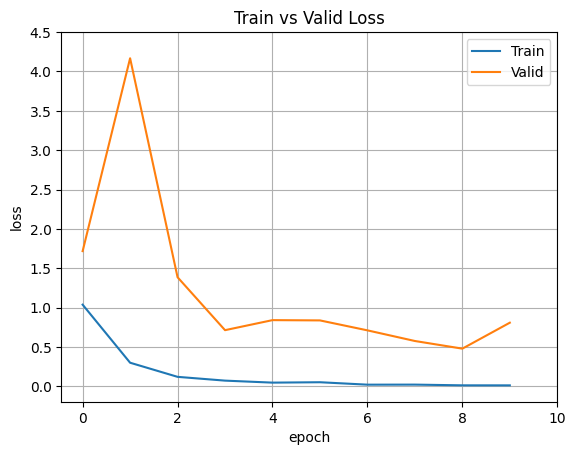

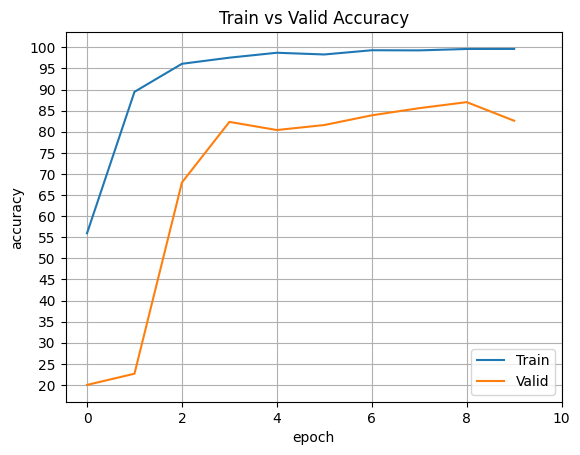

In [36]:
plt.plot(train_losses)
plt.plot(eval_losses)
plt.xticks(np.arange(0, 11, 2))
plt.yticks(np.arange(0, 5, 0.5))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
plt.grid()

plt.show()

plt.plot(train_accu)
plt.plot(eval_accu)
# plt.ylim(95, 100)
plt.xticks(np.arange(0, 11, 2))
plt.yticks(np.arange(20, 100.5, 5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.grid()

plt.show()

In [57]:
torch.save(model.state_dict(), 'model_weights_orig.pth')

## Plots for different levels of distortions

In [42]:
with open('eval_accu_rotate.pkl', 'rb') as f:
    eval_accu_rotate = pickle.load(f)

In [44]:
angles = [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150]

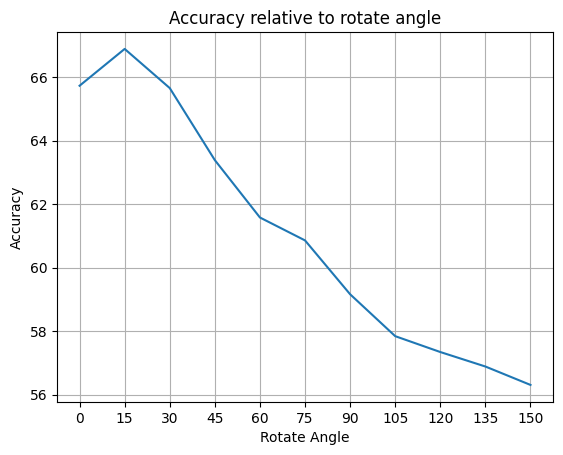

In [45]:
plt.plot(angles, eval_accu_rotate)
plt.xticks(np.arange(0, 160, 15))
# plt.yticks(np.arange(88, 100.5, 0.5))
plt.xlabel('Rotate Angle')
plt.ylabel('Accuracy')
plt.title('Accuracy relative to rotate angle')
plt.grid()

plt.show()

In [49]:
with open('eval_accu_brightness.pkl', 'rb') as f:
    eval_accu_contrast = pickle.load(f)

In [50]:
contrast = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

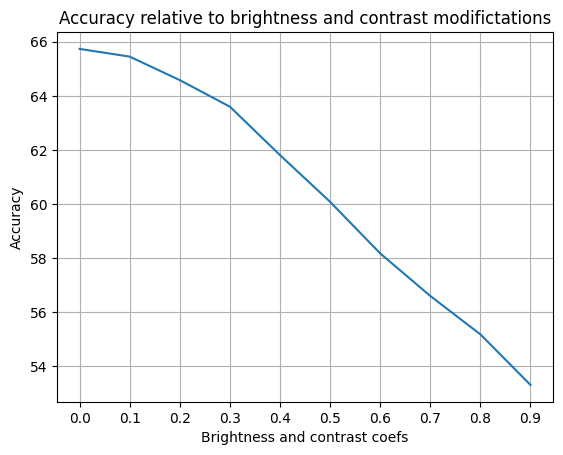

In [51]:
plt.plot(contrast, eval_accu_contrast)
plt.xticks(np.arange(0, 1, 0.1))
# plt.yticks(np.arange(88, 100.5, 0.5))
plt.xlabel('Brightness and contrast coefs')
plt.ylabel('Accuracy')
plt.title('Accuracy relative to brightness and contrast modifictations')
plt.grid()

plt.show()

In [52]:
with open('eval_accu_blur.pkl', 'rb') as f:
    eval_accu_blur = pickle.load(f)

In [53]:
blur_level = [0, '(0,1)', '(1,3)', '(3,5)', '(5,7)', '(7,9)', '(9, 11)', '(11, 13)', '(13, 15)', '(15, 17)']

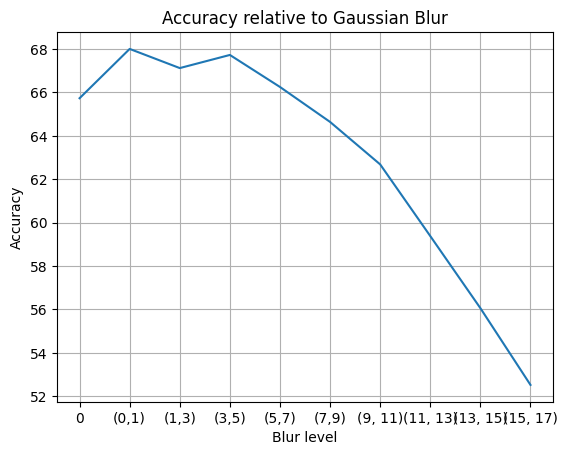

In [54]:
plt.plot(blur_level, eval_accu_blur)
# plt.xticks(np.arange(0, 1, 0.1))
# plt.yticks(np.arange(88, 100.5, 0.5))
plt.xlabel('Blur level')
plt.ylabel('Accuracy')
plt.title('Accuracy relative to Gaussian Blur')
plt.grid()

plt.show()

In [55]:
with open('eval_accu_shift.pkl', 'rb') as f:
    eval_accu_shift = pickle.load(f)

In [56]:
shift = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

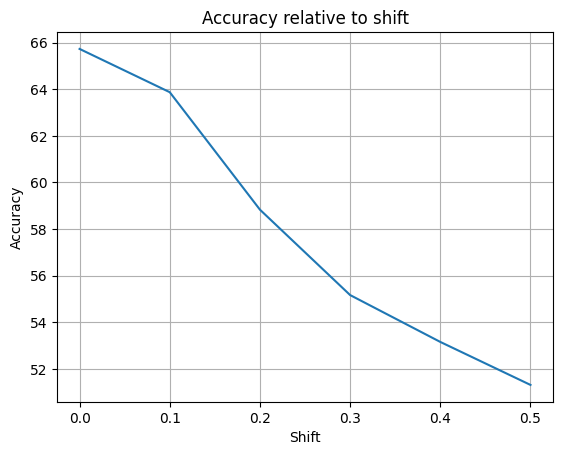

In [57]:
plt.plot(shift, eval_accu_shift)
plt.xticks(np.arange(0, 0.55, 0.1))
# plt.yticks(np.arange(88, 100.5, 0.5))
plt.xlabel('Shift')
plt.ylabel('Accuracy')
plt.title('Accuracy relative to shift')
plt.grid()

plt.show()

In [58]:
with open('eval_accu_scale.pkl', 'rb') as f:
    eval_accu_scale = pickle.load(f)

In [61]:
scale = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

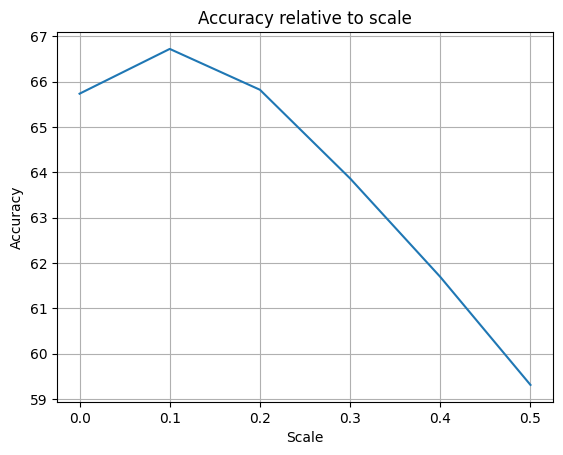

In [63]:
plt.plot(scale, eval_accu_scale)
plt.xticks(np.arange(0, 0.55, 0.1))
# plt.yticks(np.arange(88, 100.5, 0.5))
plt.xlabel('Scale')
plt.ylabel('Accuracy')
plt.title('Accuracy relative to scale')
plt.grid()

plt.show()